# DeeplabV3 for breast cancer ultrasound image segmentation

### Importing Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

 ### Function to Load and Preprocess Image and Mask Data:

In [2]:
def load_segmentation_data(img_paths, mask_paths, shape=256):
    """Load and preprocess image and mask data"""
    images = []
    masks = []
    classes = []

    file_pairs_arr = []
    # Get image names
    for img_path in img_paths:
        img_names = os.listdir(img_path)
        base_names = list(set(name.split(')')[0] for name in img_names))
        file_pairs = [(f"{base}).png", f"{base})_mask.png") for base in base_names]
        file_pairs_arr.append(file_pairs)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((shape, shape)),
        transforms.ToTensor()
    ])

    for i,file_pairs in enumerate(file_pairs_arr):
        for img_name, mask_name in file_pairs:
            img = Image.open(os.path.join(img_paths[i], img_name)).convert('L')
            mask = Image.open(os.path.join(mask_paths[i], mask_name)).convert('L')

            img_tensor = transform(img)
            mask_tensor = transform(mask)

            images.append(img_tensor)
            masks.append(mask_tensor)
            classes.append(torch.tensor(i))

    return torch.stack(images), torch.stack(masks), torch.stack(classes)

### Custom Dataset Class for Breast Cancer Ultrasound Image Segmentation:

In [3]:
class CustomDataset(Dataset):
    """Custom dataset for breast cancer segmentation"""

    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

In [4]:
class AugmentedDataset(Dataset):
    """Custom dataset with torchvision augmentations for breast cancer segmentation"""
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks
        self.train = train

        # Basic normalization and conversion
        self.normalize = transforms.Normalize(mean=[0.485], std=[0.229])

        # Training augmentations
        self.train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAffine(
                degrees=30,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),
                fill=0
            ),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2
            )
        ])

    def __len__(self):
        return len(self.images)

    def apply_transforms_to_both(self, image, mask):
        """Apply same spatial transforms to both image and mask"""
        # Convert to PIL Image for transforms
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        if isinstance(mask, torch.Tensor):
            mask = transforms.ToPILImage()(mask)

        # Generate random values for transforms
        if random.random() < 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        if random.random() < 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)

        if random.random() < 0.5:
            angle = random.uniform(-30, 30)
            image = transforms.functional.rotate(image, angle, fill=0)
            mask = transforms.functional.rotate(mask, angle, fill=0)

        if random.random() < 0.5:
            scale = random.uniform(0.9, 1.1)
            trans_x = random.uniform(-0.1, 0.1)
            trans_y = random.uniform(-0.1, 0.1)

            width, height = image.size
            max_dx = trans_x * width
            max_dy = trans_y * height
            translations = (np.round(random.uniform(-max_dx, max_dx)),
                          np.round(random.uniform(-max_dy, max_dy)))

            image = transforms.functional.affine(image, 0, translations, scale, 0, fill=0)
            mask = transforms.functional.affine(mask, 0, translations, scale, 0, fill=0)

        return image, mask

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.train:
            image, mask = self.apply_transforms_to_both(image, mask)

        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        if not isinstance(mask, torch.Tensor):
            mask = transforms.ToTensor()(mask)

        # Ensure the image has 3 channels
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        image = self.normalize(image)
        return image, mask

In [5]:
def get_data_loaders(images, masks, classes, batch_size):
    """Create data loaders with augmentation and stratification"""
    # First split: separate test set
    X_train_val, X_test, y_train_val, y_test, classes_train_val, _ = train_test_split(
        images, masks, classes,
        test_size=0.2,  # 20% for test
        random_state=42,
        stratify=classes
    )

    # Second split: separate train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=0.125,  # 10% of total (0.125 of 80% = 10% of total)
        random_state=42,
        stratify=classes_train_val
    )

    # Create datasets
    train_dataset = AugmentedDataset(X_train, y_train, train=True)
    val_dataset = AugmentedDataset(X_val, y_val, train=False)
    test_dataset = AugmentedDataset(X_test, y_test, train=False)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

### IoU Calculation:

In [6]:
# IoU Calculation
def calculate_iou(preds, targets, threshold=0.5):
    """Calculates IoU score"""
    preds = (preds > threshold).float()  # Apply threshold to get binary mask
    intersection = torch.sum(preds * targets)
    union = torch.sum(preds) + torch.sum(targets) - intersection
    iou = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero
    return iou

### Load and Preprocess Image and Mask Data:

In [16]:
TEST_SPLIT = 0.2          # Validation split ratio
VAL_SPLIT = 0.875         # 10/80 after test split
RANDOM_SEED = 42          # Random seed for reproducibility
# IMAGE_SIZE = 256          # Input image size
BATCH_SIZE = 16           # Batch size for training
# LEARNING_RATE = 0.001     # Initial learning rate
# WEIGHT_DECAY = 1e-6       # Weight decay for regularization
NUM_EPOCHS = 50           # Number of training epochs

# # Set device (GPU/CPU)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
root_data_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
data_paths = [root_data_path+'normal', root_data_path+'benign', root_data_path+'malignant']
images, masks, classes = load_segmentation_data(data_paths, data_paths)

train_loader, val_loader, test_loader = get_data_loaders(
    images=images,
    masks=masks,
    classes=classes,
    batch_size=BATCH_SIZE
)

In [12]:
# Loading the pre-trained DeepLabV3 model from torchvision
model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
# Initialize lists to track metrics
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
train_dice = []
val_dice = []
train_iou = []
val_iou = []

In [ ]:
'''
# Load and prepare data
images, masks = load_segmentation_data('Dataset_BUSI_with_GT/malignant', 'Dataset_BUSI_with_GT/malignant')

# Set test split ratio and random seed for reproducibility
TEST_SPLIT = 0.2
RANDOM_SEED = 42

X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=TEST_SPLIT, random_state=RANDOM_SEED
)

# Create data loaders
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

# Set num_workers to 0 to avoid multiprocessing issues on macOS
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

# Loading the pre-trained DeepLabV3 model from torchvision
model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Initialize lists to track metrics
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
train_dice = []
val_dice = []
train_iou = []
val_iou = []
'''

### Training Loop:

In [18]:
# Training loop with visualization
# num_epochs = 60
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    epoch_iou = 0.0
    epoch_dice = 0.0
    correct = 0
    total = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Ensure masks have a single channel
        masks = masks.squeeze(1)  # Remove the extra channels, convert to [batch_size, height, width]

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)['out']

        # Ensure outputs are also single-channel and match the mask shape
        outputs = outputs.squeeze(1)  # [batch_size, height, width]

        # Compute loss
        loss = criterion(outputs, masks.float())  # BCEWithLogitsLoss expects single-channel outputs and targets
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate Dice and IoU scores
        dice = calculate_iou(outputs, masks)
        epoch_dice += dice.item()

        iou = calculate_iou(outputs, masks)
        epoch_iou += iou.item()

    # Store metrics for the epoch
    train_loss.append(running_loss / len(train_loader))
    train_dice.append(epoch_dice / len(train_loader))
    train_iou.append(epoch_iou / len(train_loader))

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {train_loss[-1]:.4f}, Dice: {train_dice[-1]:.4f}, IoU: {train_iou[-1]:.4f}")

Epoch 1/50, Loss: 0.1590, Dice: 0.6762, IoU: 0.6762
Epoch 2/50, Loss: 0.1506, Dice: 0.6854, IoU: 0.6854
Epoch 3/50, Loss: 0.1376, Dice: 0.6903, IoU: 0.6903
Epoch 4/50, Loss: 0.1294, Dice: 0.6761, IoU: 0.6761
Epoch 5/50, Loss: 0.1203, Dice: 0.6992, IoU: 0.6992
Epoch 6/50, Loss: 0.1135, Dice: 0.7132, IoU: 0.7132
Epoch 7/50, Loss: 0.1072, Dice: 0.7111, IoU: 0.7111
Epoch 8/50, Loss: 0.0958, Dice: 0.7453, IoU: 0.7453
Epoch 9/50, Loss: 0.0990, Dice: 0.7204, IoU: 0.7204
Epoch 10/50, Loss: 0.0972, Dice: 0.7025, IoU: 0.7025
Epoch 11/50, Loss: 0.0986, Dice: 0.6922, IoU: 0.6922
Epoch 12/50, Loss: 0.0879, Dice: 0.7283, IoU: 0.7283
Epoch 13/50, Loss: 0.0820, Dice: 0.7413, IoU: 0.7413
Epoch 14/50, Loss: 0.0872, Dice: 0.7101, IoU: 0.7101
Epoch 15/50, Loss: 0.0808, Dice: 0.7375, IoU: 0.7375
Epoch 16/50, Loss: 0.0772, Dice: 0.7402, IoU: 0.7402
Epoch 17/50, Loss: 0.0723, Dice: 0.7501, IoU: 0.7501
Epoch 18/50, Loss: 0.0688, Dice: 0.7512, IoU: 0.7512
Epoch 19/50, Loss: 0.0665, Dice: 0.7764, IoU: 0.7764
Ep

### Save the Trained Model:

In [19]:
# Save the trained model
torch.save(model.state_dict(), 'deeplabv3_breast_cancer_model.pth')

# evaluate

- get iou for model on test set
- visualise a bit

In [35]:
def iou_coef(pred, groundtruth, smooth=1e-10):
    """Calculate IoU (Intersection over Union) coefficient"""
    # # Ensure inputs are tensors
    # if not isinstance(pred, torch.Tensor):
    #     pred = torch.tensor(pred)
    # if not isinstance(groundtruth, torch.Tensor):
    #     groundtruth = torch.tensor(groundtruth)
        
    # intersection = torch.sum(pred * groundtruth)
    # union = torch.sum(pred) + torch.sum(groundtruth) - intersection
    # iou = (intersection + smooth) / (union + smooth)
    # return iou
    
    # Ensure inputs are tensors
    if not isinstance(pred, torch.Tensor):
        pred = torch.tensor(pred, dtype=torch.float32)
    if not isinstance(groundtruth, torch.Tensor):
        groundtruth = torch.tensor(groundtruth, dtype=torch.float32)

    # Binarize inputs if they are not binary
    pred = (pred > 0.5).float()
    groundtruth = (groundtruth > 0.5).float()

    # Calculate intersection and union
    intersection = torch.sum(pred * groundtruth)
    union = torch.sum(pred) + torch.sum(groundtruth) - intersection

    # Compute IoU
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

In [30]:
def evaluation(model, test_loader, device):
    predicted_masks = []
    original_masks = []
    ious = []

    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
                
            images = images.to(device)
            masks = masks.to(device)
            predictions = model(images)
            
            # Convert tensors to numpy arrays
            image = images[0].cpu().numpy().squeeze()
            mask = masks[0].cpu().numpy().squeeze()
            # pred = predictions[0].cpu().numpy().squeeze()
            pred = predictions['out'][0].cpu().numpy().squeeze()

            predicted_masks.append(pred)
            original_masks.append(mask)

            this_iou = iou_coef(pred, mask)
            ious.append(this_iou)

    mean_iou = np.mean(np.array(ious))
    return predicted_masks, original_masks, mean_iou
    # return mean_iou

In [36]:
pred_masks, og_masks, iou = evaluation(model, test_loader, device)

In [37]:
iou

0.5339717701077606

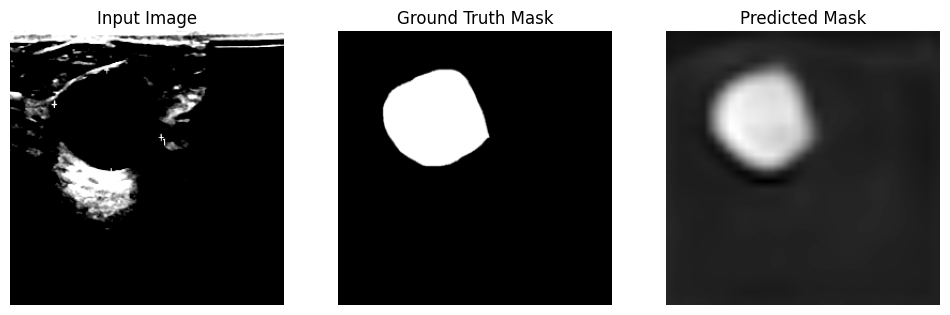

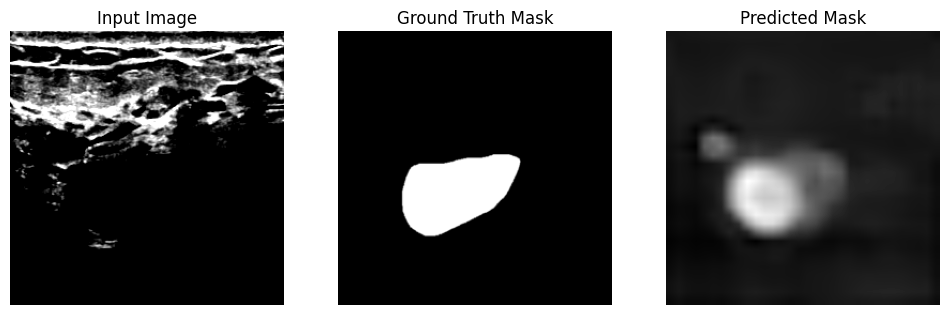

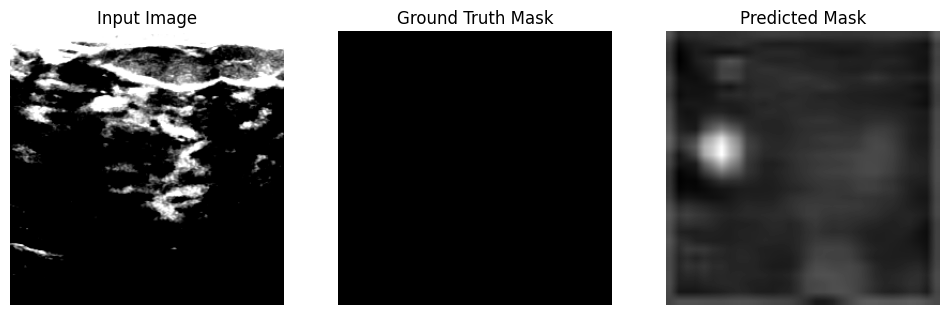

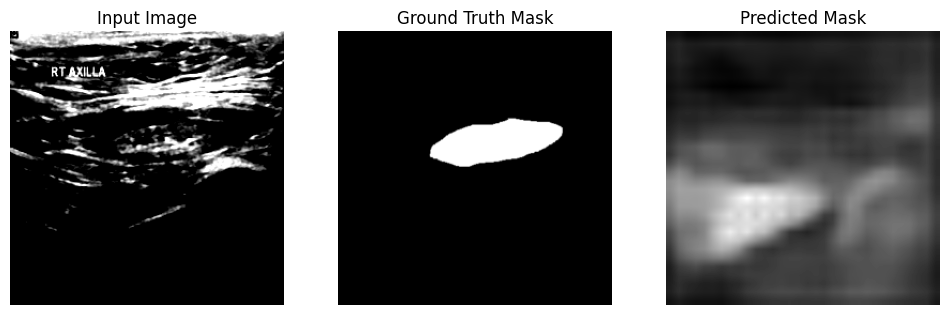

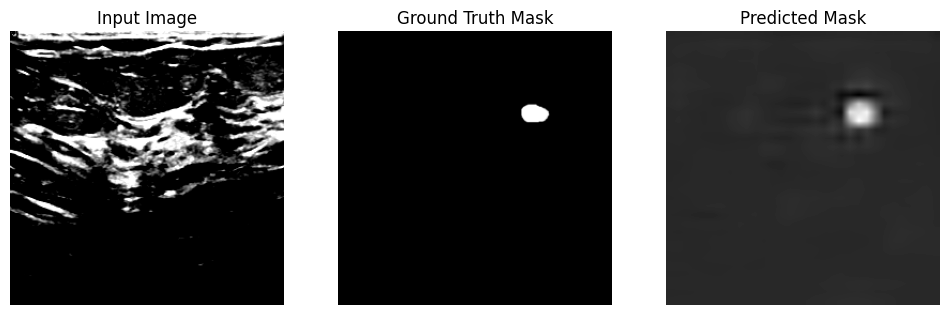

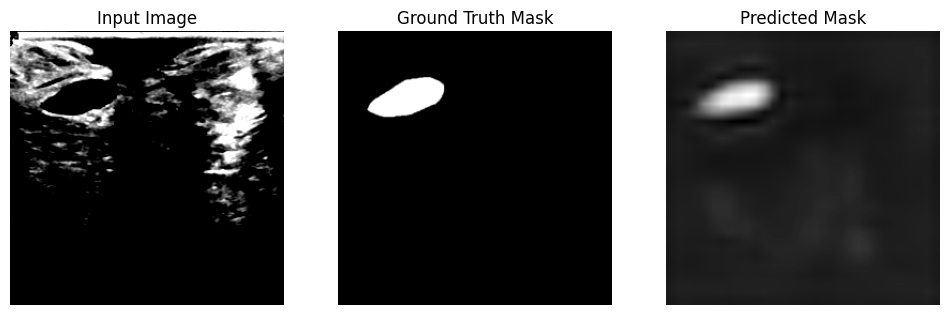

In [40]:
model.eval()
with torch.no_grad():
    i=0
    for images, masks in test_loader:
        # Get a sample from the batch to visualize
        sample_image = images[0].cpu().numpy().transpose(1, 2, 0)
        # sample_mask = masks[0].cpu().numpy()
        sample_mask = og_masks[i]
        # output_mask = torch.sigmoid(outputs[0]).cpu().numpy()  # Use sigmoid for binary output
        output_mask = pred_masks[i]
    
        # Plotting the image, true mask, and predicted mask
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(sample_image)
        plt.title("Input Image")
        plt.axis('off')
    
        plt.subplot(1, 3, 2)
        plt.imshow(sample_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
    
        plt.subplot(1, 3, 3)
        plt.imshow(output_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
        plt.show()
        i+=1
        if i>5:
            break